> # **Import Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import missingno as msno


from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder, StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix
from sklearn.metrics import classification_report


import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.layers import Dropout
from keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam


import warnings
warnings.filterwarnings('ignore')

# **Import and Explore Data**

In [2]:
df = pd.read_csv('/kaggle/input/breast-cancer-wisconsin-data/data.csv')

In [3]:
df.head().style.background_gradient(cmap="plasma")

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
0,842302,M,17.990000,10.380000,122.800000,1001.000000,0.118400,0.277600,0.300100,0.147100,0.241900,0.078710,1.095000,0.905300,8.589000,153.400000,0.006399,0.049040,0.053730,0.015870,0.030030,0.006193,25.380000,17.330000,184.600000,2019.000000,0.162200,0.665600,0.711900,0.265400,0.460100,0.118900,nan
1,842517,M,20.570000,17.770000,132.900000,1326.000000,0.084740,0.078640,0.086900,0.070170,0.181200,0.056670,0.543500,0.733900,3.398000,74.080000,0.005225,0.013080,0.018600,0.013400,0.013890,0.003532,24.990000,23.410000,158.800000,1956.000000,0.123800,0.186600,0.241600,0.186000,0.275000,0.089020,nan
2,84300903,M,19.690000,21.250000,130.000000,1203.000000,0.109600,0.159900,0.197400,0.127900,0.206900,0.059990,0.745600,0.786900,4.585000,94.030000,0.006150,0.040060,0.038320,0.020580,0.022500,0.004571,23.570000,25.530000,152.500000,1709.000000,0.144400,0.424500,0.450400,0.243000,0.361300,0.087580,nan
3,84348301,M,11.420000,20.380000,77.580000,386.100000,0.142500,0.283900,0.241400,0.105200,0.259700,0.097440,0.495600,1.156000,3.445000,27.230000,0.009110,0.074580,0.056610,0.018670,0.059630,0.009208,14.910000,26.500000,98.870000,567.700000,0.209800,0.866300,0.686900,0.257500,0.663800,0.173000,nan
4,84358402,M,20.290000,14.340000,135.100000,1297.000000,0.100300,0.132800,0.198000,0.104300,0.180900,0.058830,0.757200,0.781300,5.438000,94.440000,0.011490,0.024610,0.056880,0.018850,0.017560,0.005115,22.540000,16.670000,152.200000,1575.000000,0.137400,0.205000,0.400000,0.162500,0.236400,0.076780,nan


In [4]:
df.tail().style.background_gradient(cmap="plasma")

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst,Unnamed: 32
564,926424,M,21.560000,22.390000,142.000000,1479.000000,0.111000,0.115900,0.243900,0.138900,0.172600,0.056230,1.176000,1.256000,7.673000,158.700000,0.010300,0.028910,0.051980,0.024540,0.011140,0.004239,25.450000,26.400000,166.100000,2027.000000,0.141000,0.211300,0.410700,0.221600,0.206000,0.071150,nan
565,926682,M,20.130000,28.250000,131.200000,1261.000000,0.097800,0.103400,0.144000,0.097910,0.175200,0.055330,0.765500,2.463000,5.203000,99.040000,0.005769,0.024230,0.039500,0.016780,0.018980,0.002498,23.690000,38.250000,155.000000,1731.000000,0.116600,0.192200,0.321500,0.162800,0.257200,0.066370,nan
566,926954,M,16.600000,28.080000,108.300000,858.100000,0.084550,0.102300,0.092510,0.053020,0.159000,0.056480,0.456400,1.075000,3.425000,48.550000,0.005903,0.037310,0.047300,0.015570,0.013180,0.003892,18.980000,34.120000,126.700000,1124.000000,0.113900,0.309400,0.340300,0.141800,0.221800,0.078200,nan
567,927241,M,20.600000,29.330000,140.100000,1265.000000,0.117800,0.277000,0.351400,0.152000,0.239700,0.070160,0.726000,1.595000,5.772000,86.220000,0.006522,0.061580,0.071170,0.016640,0.023240,0.006185,25.740000,39.420000,184.600000,1821.000000,0.165000,0.868100,0.938700,0.265000,0.408700,0.124000,nan
568,92751,B,7.760000,24.540000,47.920000,181.000000,0.052630,0.043620,0.000000,0.000000,0.158700,0.058840,0.385700,1.428000,2.548000,19.150000,0.007189,0.004660,0.000000,0.000000,0.026760,0.002783,9.456000,30.370000,59.160000,268.600000,0.089960,0.064440,0.000000,0.000000,0.287100,0.070390,nan


In [5]:
df.shape

(569, 33)

In [6]:
df.columns.to_list()

['id',
 'diagnosis',
 'radius_mean',
 'texture_mean',
 'perimeter_mean',
 'area_mean',
 'smoothness_mean',
 'compactness_mean',
 'concavity_mean',
 'concave points_mean',
 'symmetry_mean',
 'fractal_dimension_mean',
 'radius_se',
 'texture_se',
 'perimeter_se',
 'area_se',
 'smoothness_se',
 'compactness_se',
 'concavity_se',
 'concave points_se',
 'symmetry_se',
 'fractal_dimension_se',
 'radius_worst',
 'texture_worst',
 'perimeter_worst',
 'area_worst',
 'smoothness_worst',
 'compactness_worst',
 'concavity_worst',
 'concave points_worst',
 'symmetry_worst',
 'fractal_dimension_worst',
 'Unnamed: 32']

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

In [8]:
df.describe().T.style.background_gradient(cmap="PuBu")

,count,mean,std,min,25%,50%,75%,max
id,569.000000,30371831.432337,125020585.612224,8670.000000,869218.000000,906024.000000,8813129.000000,911320502.000000
radius_mean,569.000000,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.110000
texture_mean,569.000000,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.280000
perimeter_mean,569.000000,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.500000
area_mean,569.000000,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.000000
smoothness_mean,569.000000,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.163400
compactness_mean,569.000000,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.345400
concavity_mean,569.000000,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.426800
concave points_mean,569.000000,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.201200
symmetry_mean,569.000000,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.304000


In [9]:
df.isnull().sum()

id                           0
diagnosis                    0
radius_mean                  0
texture_mean                 0
perimeter_mean               0
area_mean                    0
smoothness_mean              0
compactness_mean             0
concavity_mean               0
concave points_mean          0
symmetry_mean                0
fractal_dimension_mean       0
radius_se                    0
texture_se                   0
perimeter_se                 0
area_se                      0
smoothness_se                0
compactness_se               0
concavity_se                 0
concave points_se            0
symmetry_se                  0
fractal_dimension_se         0
radius_worst                 0
texture_worst                0
perimeter_worst              0
area_worst                   0
smoothness_worst             0
compactness_worst            0
concavity_worst              0
concave points_worst         0
symmetry_worst               0
fractal_dimension_worst      0
Unnamed:

In [10]:
df.nunique()

id                         569
diagnosis                    2
radius_mean                456
texture_mean               479
perimeter_mean             522
area_mean                  539
smoothness_mean            474
compactness_mean           537
concavity_mean             537
concave points_mean        542
symmetry_mean              432
fractal_dimension_mean     499
radius_se                  540
texture_se                 519
perimeter_se               533
area_se                    528
smoothness_se              547
compactness_se             541
concavity_se               533
concave points_se          507
symmetry_se                498
fractal_dimension_se       545
radius_worst               457
texture_worst              511
perimeter_worst            514
area_worst                 544
smoothness_worst           411
compactness_worst          529
concavity_worst            539
concave points_worst       492
symmetry_worst             500
fractal_dimension_worst    535
Unnamed:

In [11]:
pd.DataFrame(df["diagnosis"].value_counts()).style.background_gradient(cmap="PuBu")

,count
diagnosis,
B,357
M,212


* Delete the empty column that does not contain a value, as well as the ID column

In [12]:
df.drop(columns=['id', 'Unnamed: 32'], inplace=True)

In [13]:
df.head(3).style.background_gradient(cmap="plasma")

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.990000,10.380000,122.800000,1001.000000,0.118400,0.277600,0.300100,0.147100,0.241900,0.078710,1.095000,0.905300,8.589000,153.400000,0.006399,0.049040,0.053730,0.015870,0.030030,0.006193,25.380000,17.330000,184.600000,2019.000000,0.162200,0.665600,0.711900,0.265400,0.460100,0.118900
1,M,20.570000,17.770000,132.900000,1326.000000,0.084740,0.078640,0.086900,0.070170,0.181200,0.056670,0.543500,0.733900,3.398000,74.080000,0.005225,0.013080,0.018600,0.013400,0.013890,0.003532,24.990000,23.410000,158.800000,1956.000000,0.123800,0.186600,0.241600,0.186000,0.275000,0.089020
2,M,19.690000,21.250000,130.000000,1203.000000,0.109600,0.159900,0.197400,0.127900,0.206900,0.059990,0.745600,0.786900,4.585000,94.030000,0.006150,0.040060,0.038320,0.020580,0.022500,0.004571,23.570000,25.530000,152.500000,1709.000000,0.144400,0.424500,0.450400,0.243000,0.361300,0.087580


In [14]:
df.duplicated().sum()

0

# **Outliers**

In [15]:
# general method to count outliers

def count_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers


for col in df.select_dtypes(include=np.number).columns:
    print("{:<15} {:>6}".format(col, len(count_outliers(df, col))))

radius_mean         14
texture_mean         7
perimeter_mean      13
area_mean           25
smoothness_mean      6
compactness_mean     16
concavity_mean      18
concave points_mean     10
symmetry_mean       15
fractal_dimension_mean     15
radius_se           38
texture_se          20
perimeter_se        38
area_se             65
smoothness_se       30
compactness_se      28
concavity_se        22
concave points_se     19
symmetry_se         27
fractal_dimension_se     28
radius_worst        17
texture_worst        5
perimeter_worst     15
area_worst          35
smoothness_worst      7
compactness_worst     16
concavity_worst     12
concave points_worst      0
symmetry_worst      23
fractal_dimension_worst     24


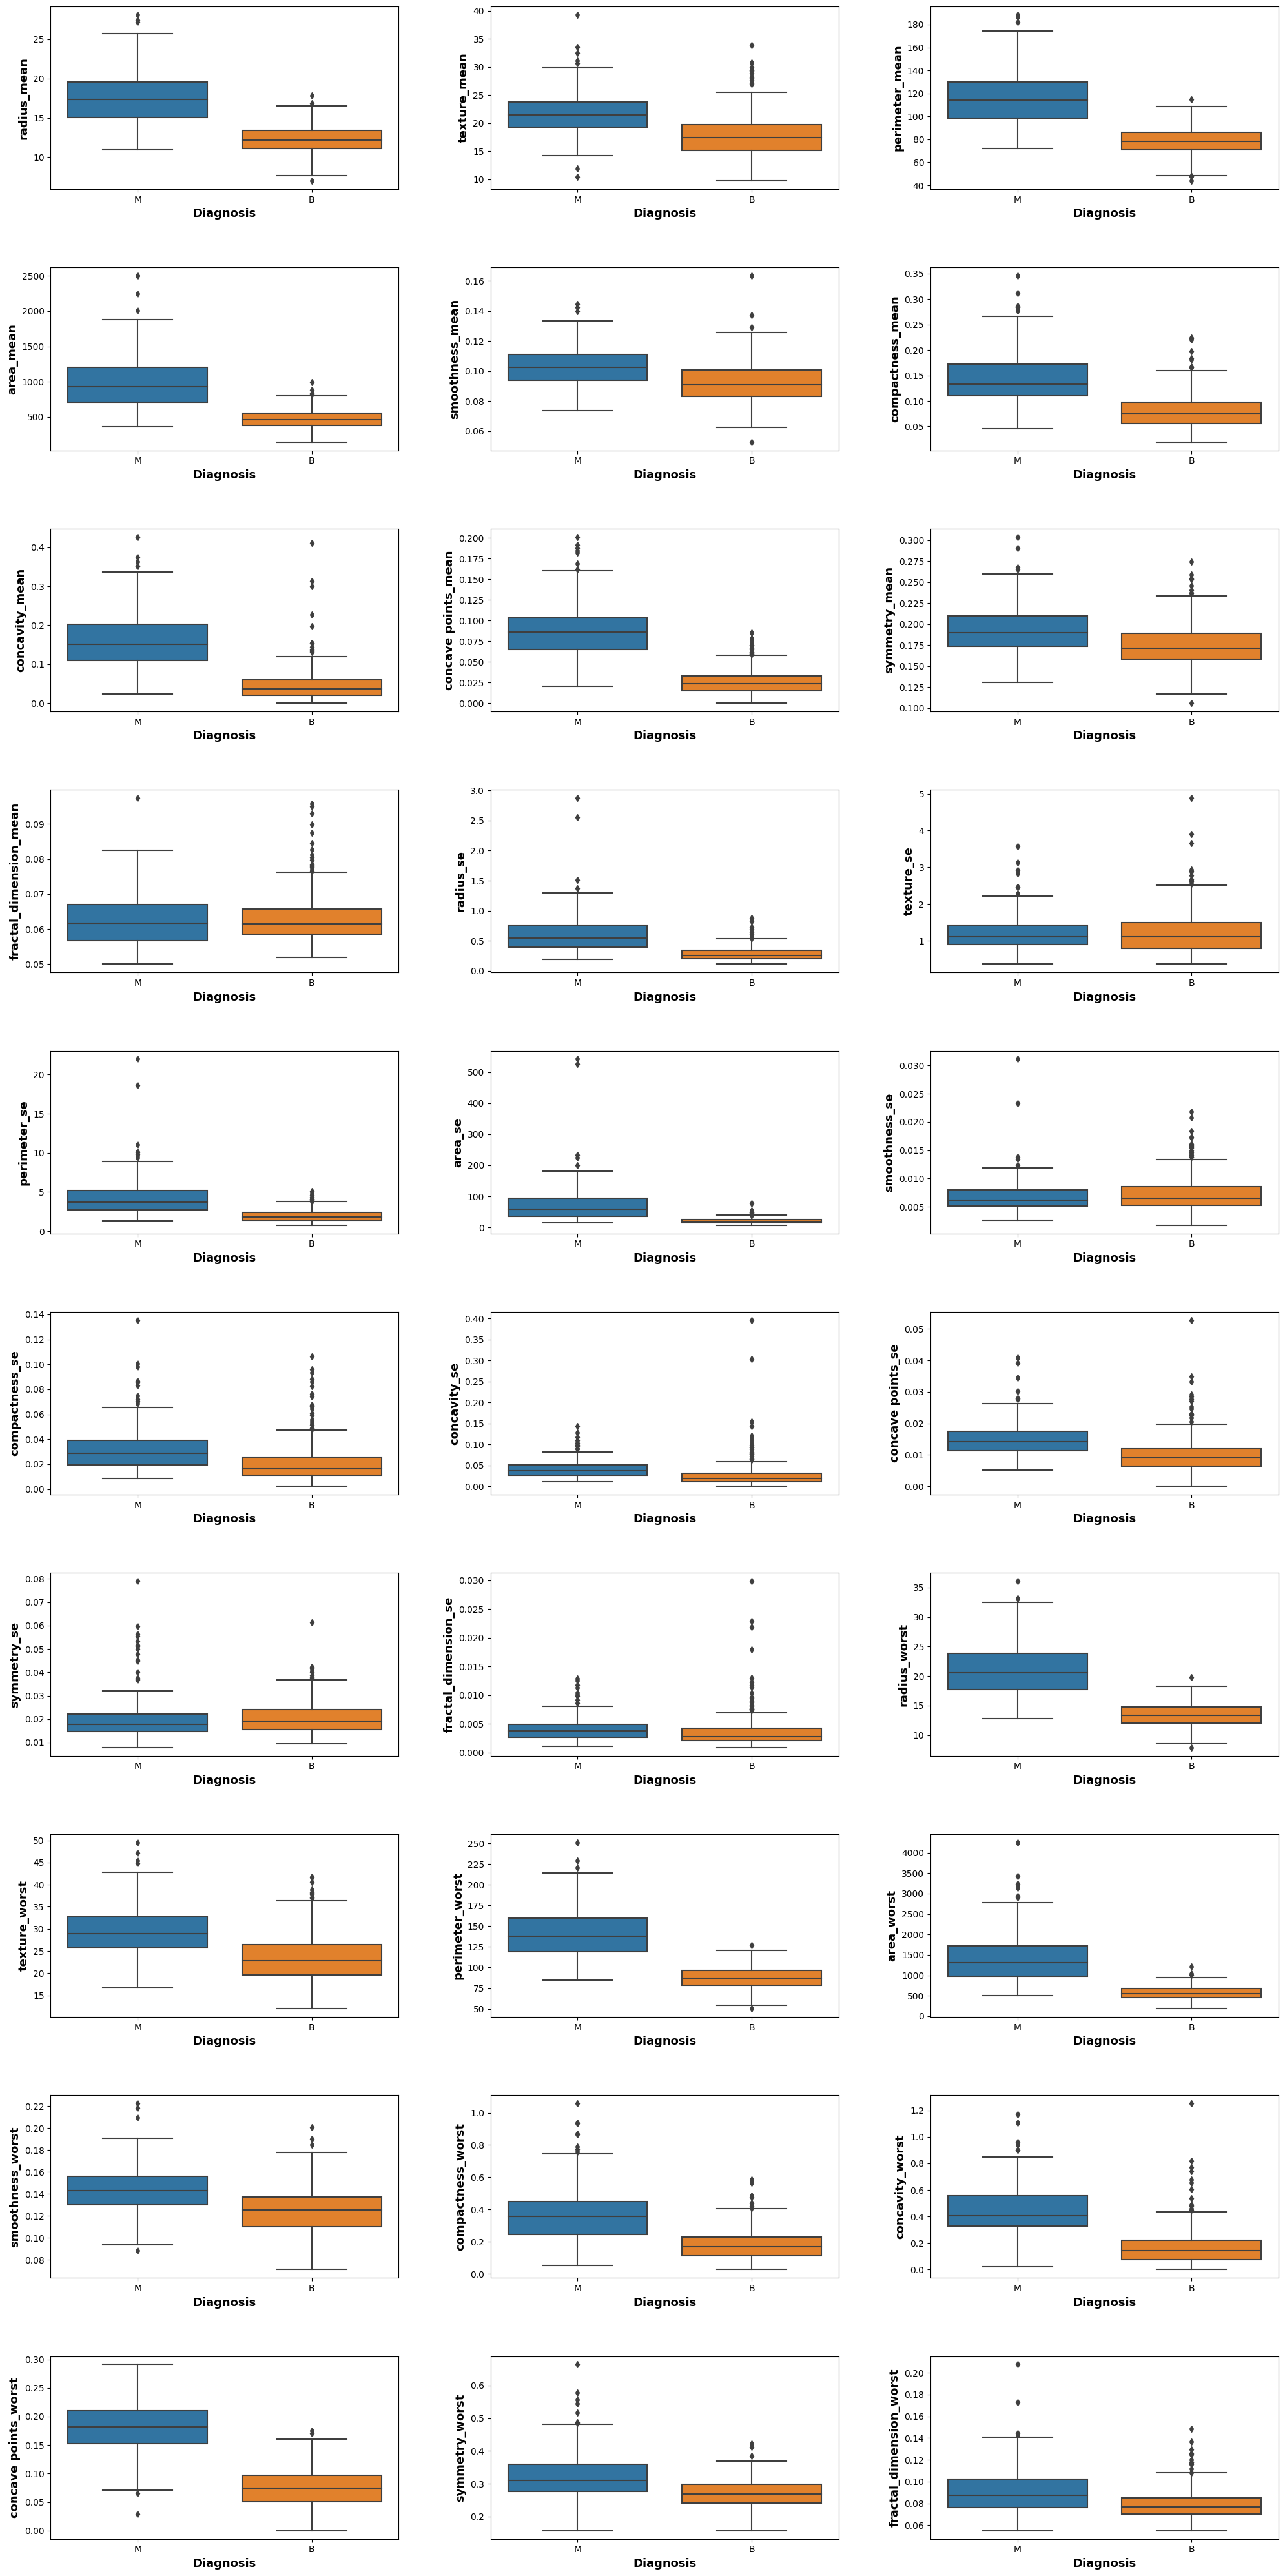

In [16]:
# let's see outliers of each column

fig, ax = plt.subplots(10, 3, figsize=(20, 40))
ax = ax.flatten()

for i, col in enumerate(df.columns[1:]):
    sns.boxplot(x='diagnosis', y=col, data=df, ax=ax[i])
    ax[i].set_xlabel('Diagnosis', fontsize = 13, fontweight = 'bold')
    ax[i].set_ylabel(col, fontsize = 13, fontweight = 'bold')
    
plt.tight_layout(w_pad=5, h_pad=5)
plt.show()

# **Visulaization**

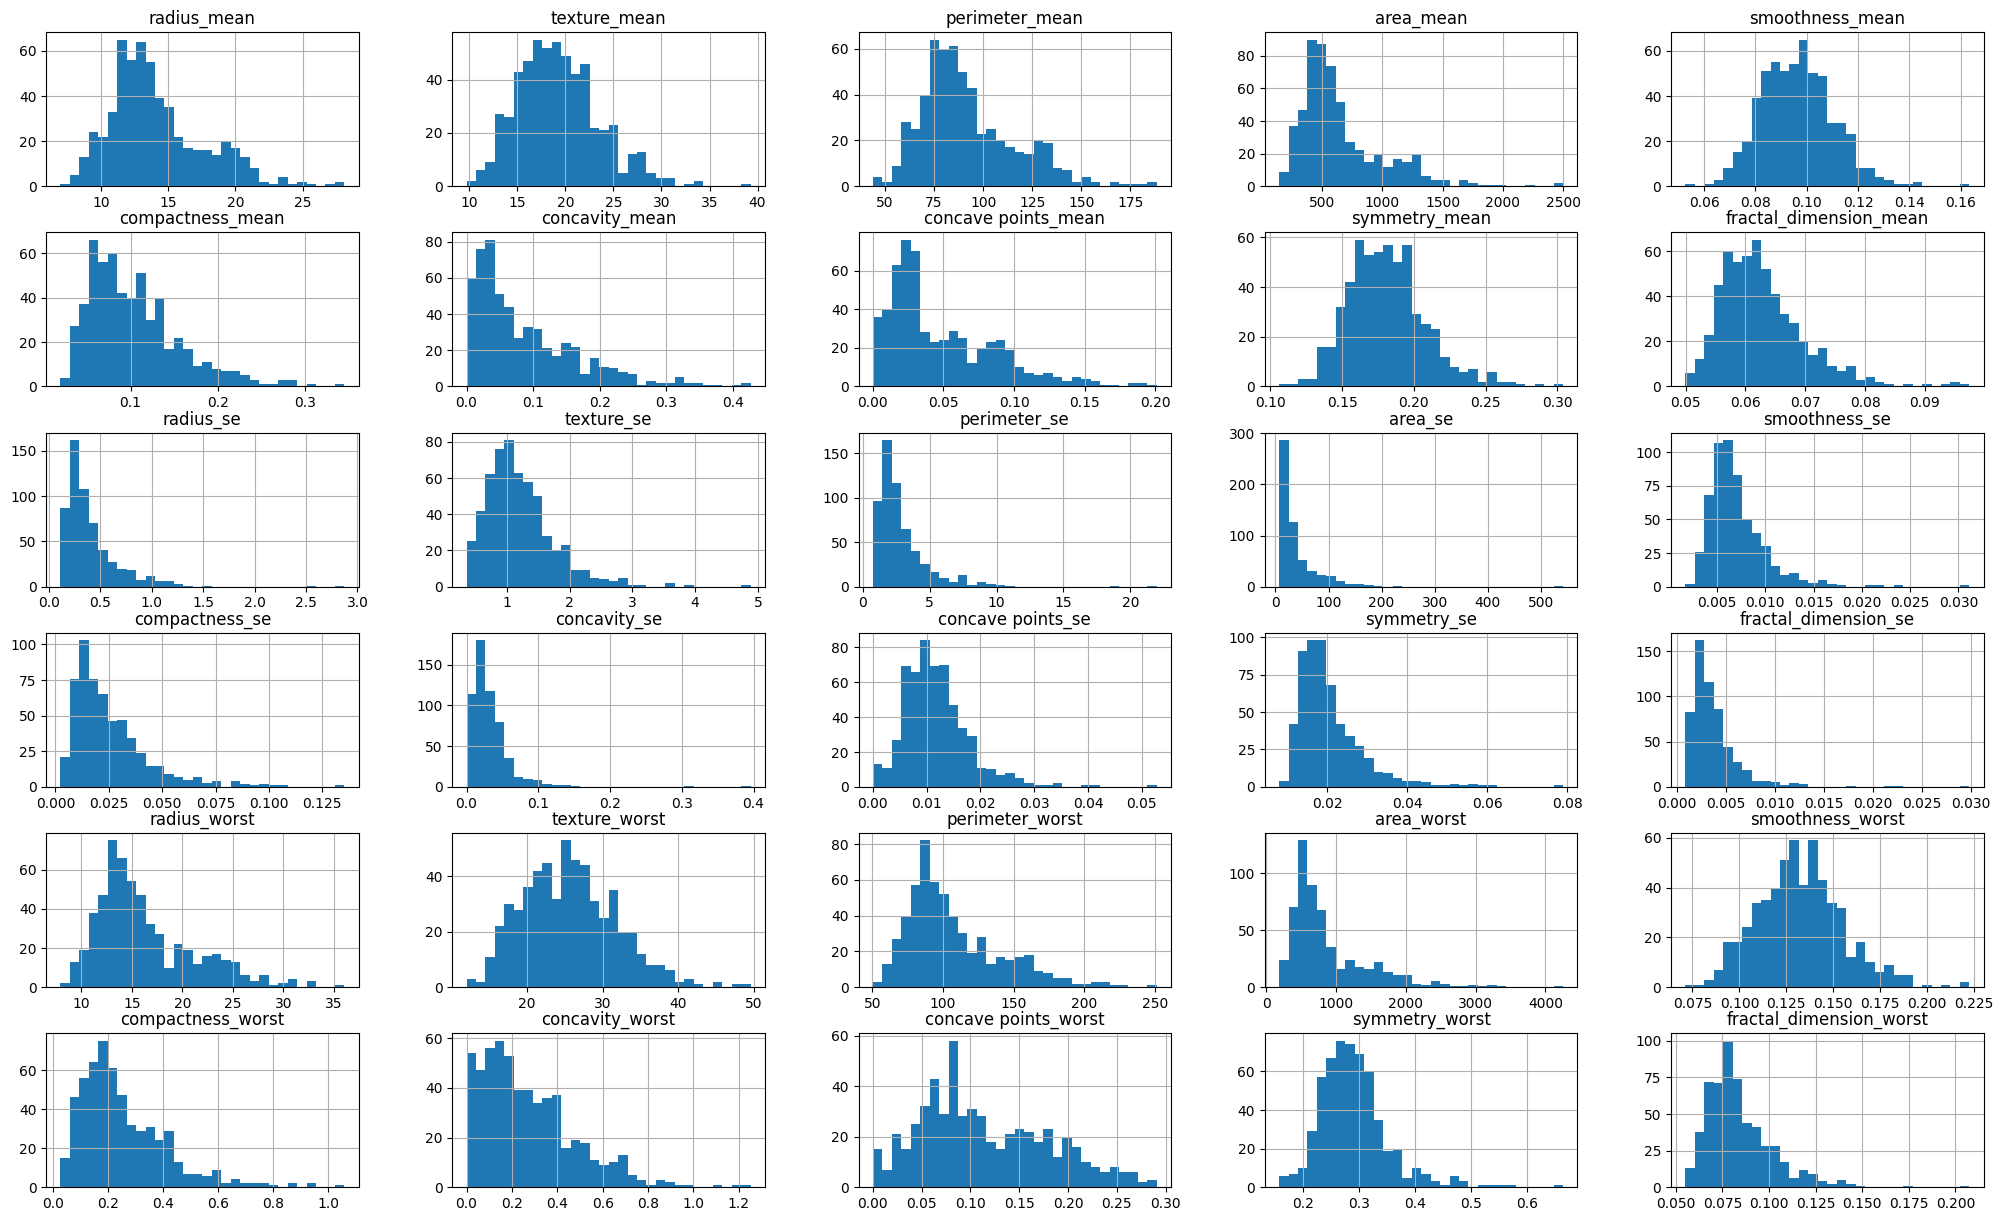

In [17]:
df.hist(bins=30, figsize=(25,15))
plt.show()

Text(0.5, 1.0, 'diagnosis Rate')

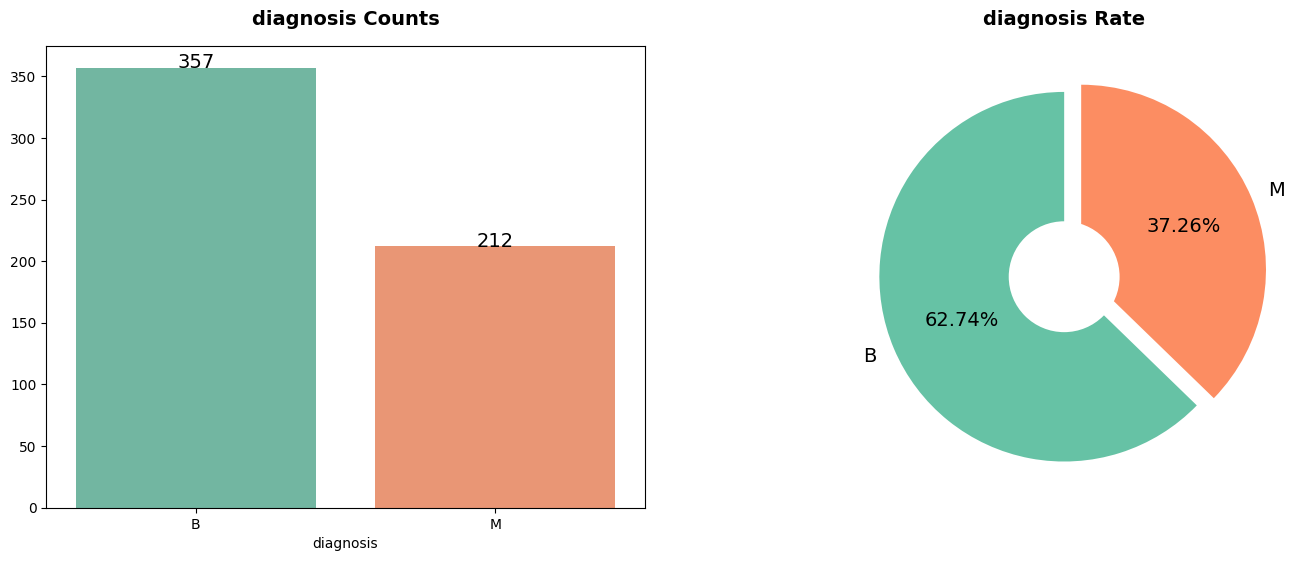

In [18]:
#Visualization to show diagnosis in Counts.
plt.figure(figsize=(17,6))
plt.subplot(1,2,1)
diagnosis_rate = df["diagnosis"].value_counts()
sns.barplot(x=diagnosis_rate.index,y=diagnosis_rate.values,palette= 'Set2')
plt.title("diagnosis Counts",fontweight="black", size=14, pad=15)
for i, v in enumerate(diagnosis_rate.values):
    plt.text(i, v, v,ha="center", fontsize=14)

#Visualization to show diagnosis in Percentage.
plt.subplot(1,2,2)
colors = sns.color_palette('Set2', len(diagnosis_rate))
plt.pie(diagnosis_rate, labels=["B","M"], autopct="%.2f%%", textprops={"size":14},
        colors = colors,explode=[0,0.1],startangle=90)
center_circle = plt.Circle((0, 0), 0.3, fc='white')
fig = plt.gcf()
fig.gca().add_artist(center_circle)
plt.title("diagnosis Rate",fontweight="black",size=14 ,pad=15)

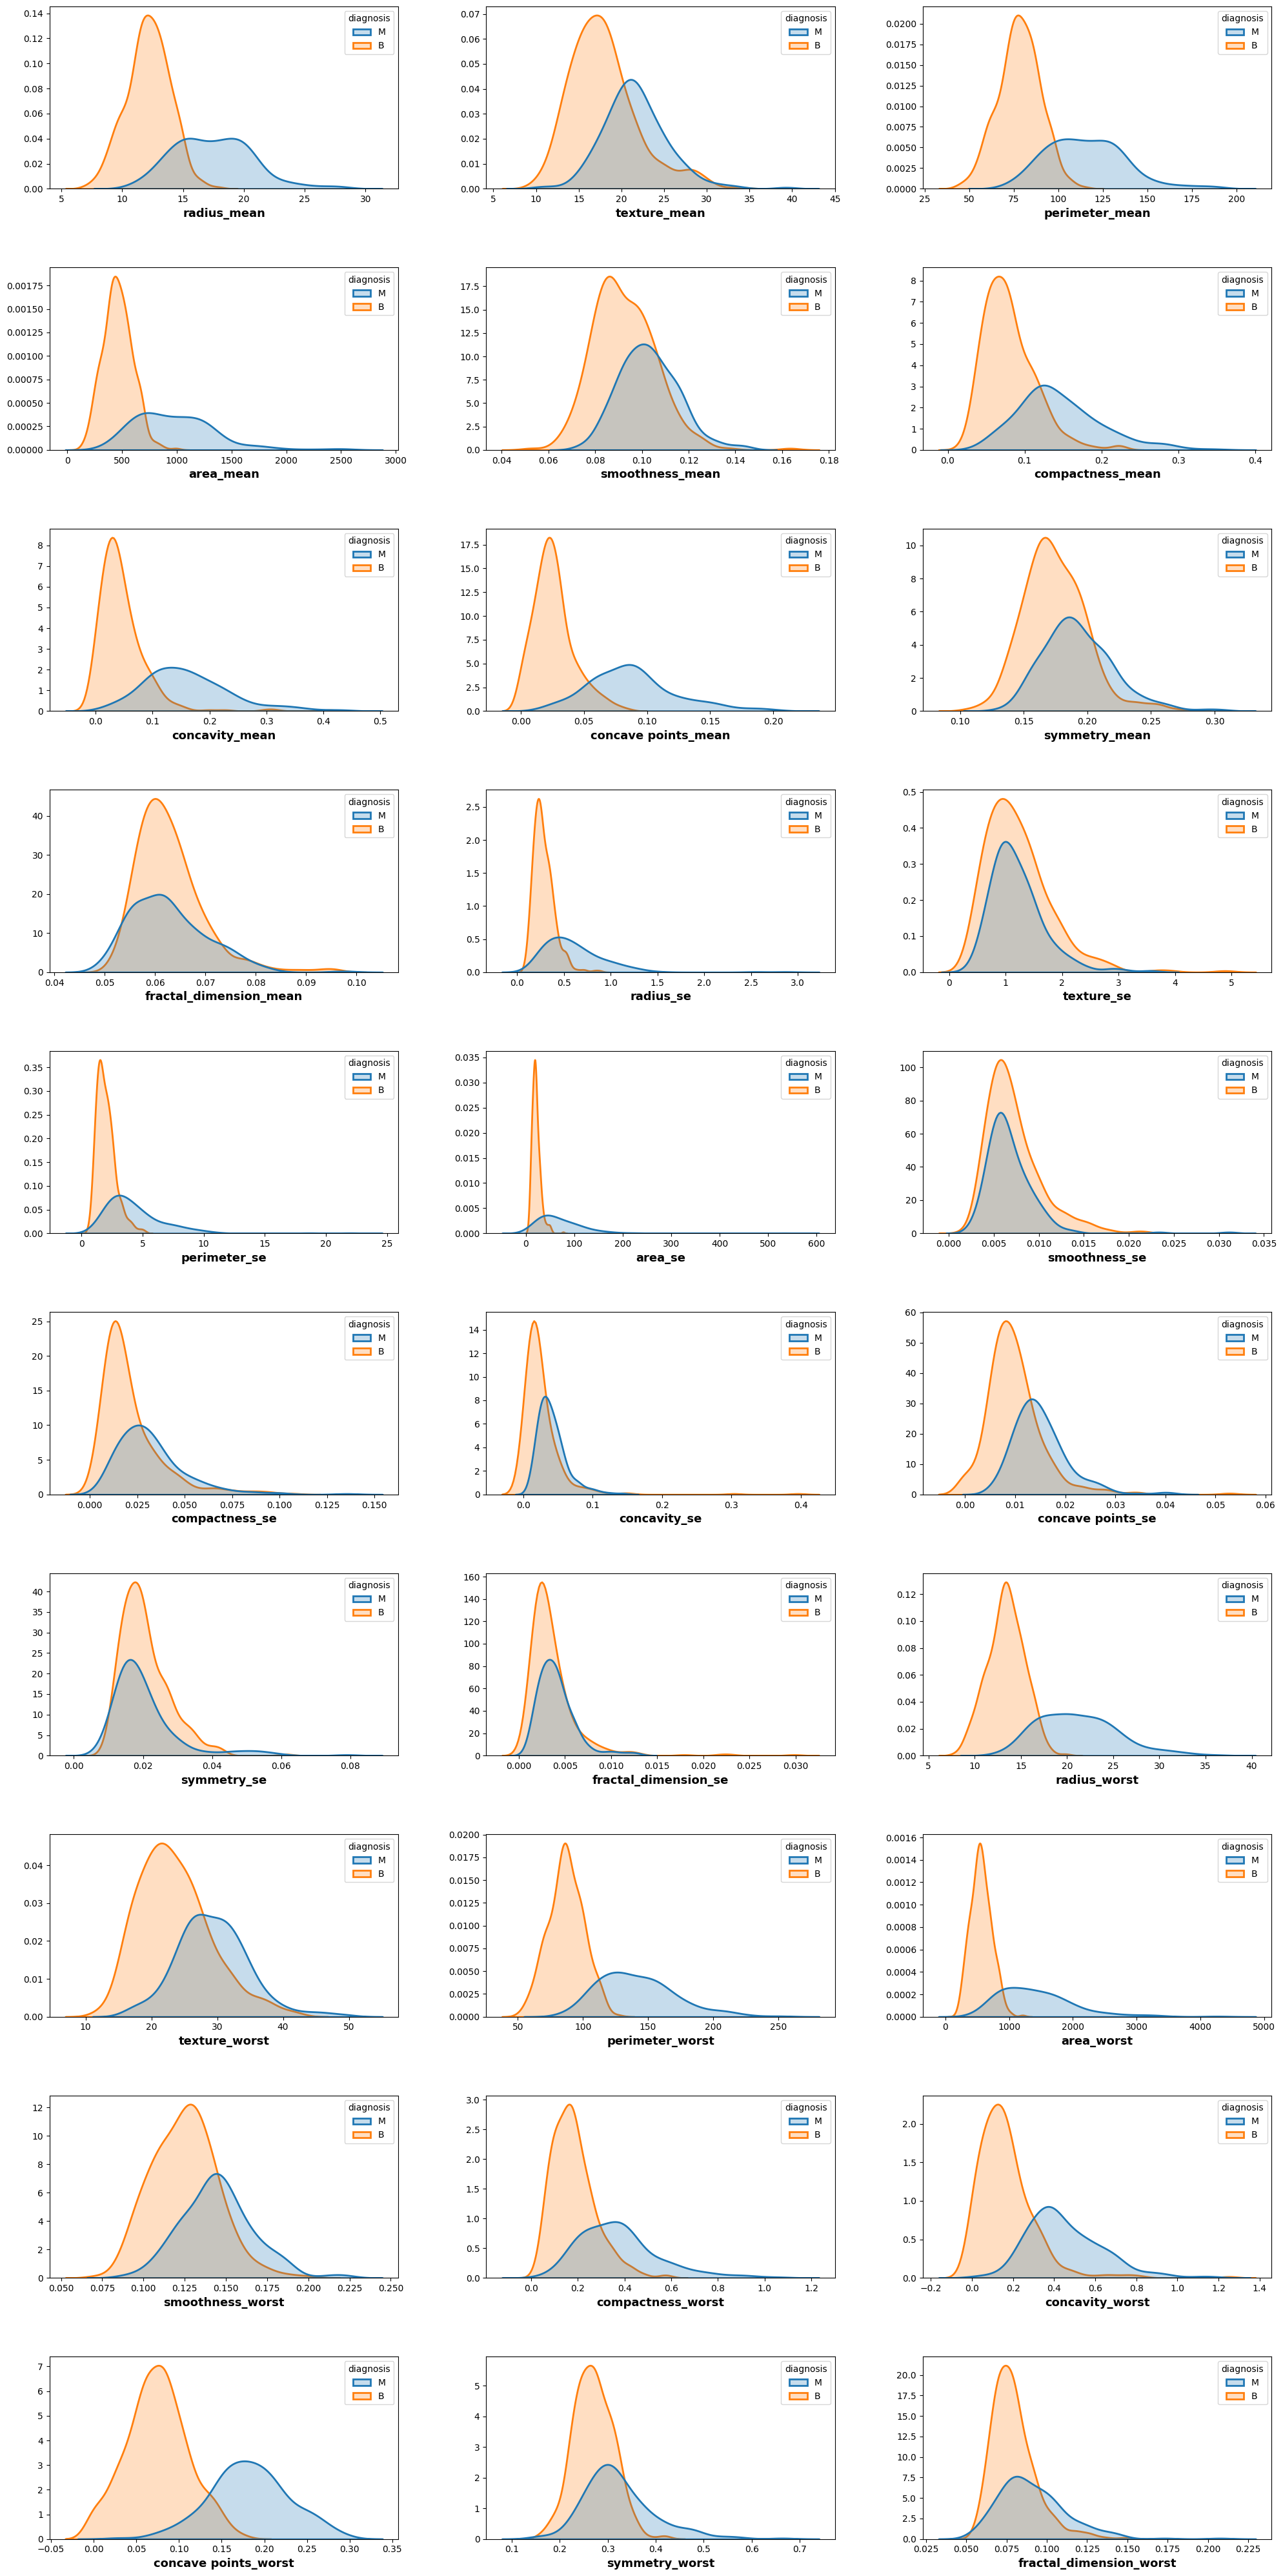

In [19]:
fig, ax = plt.subplots(10, 3, figsize=(20, 40))
ax = ax.flatten()

for i, col in enumerate(df.columns[1:]):
    sns.kdeplot(x=col, data=df, ax=ax[i], fill=True, lw=2, hue = 'diagnosis',color = "Green",shade = True)
    ax[i].set_xlabel(col, fontsize = 13, fontweight = 'bold')
    ax[i].set_ylabel('')
    
plt.tight_layout(w_pad=5, h_pad=5)
plt.show()

* It appears from the figure above that higher x-axis values ​​are associated with malignant tumors, while lower values ​​indicate benign tumors.

# **convert target column to numarical column**

In [20]:
x=df.drop('diagnosis',axis=1) # define features and target
y=df['diagnosis']    #target

In [21]:
lab = LabelEncoder()
y = lab.fit_transform(y)

# Data Scaling



In [22]:
scaler = MinMaxScaler() # max value = 1 , min value = 0 
x = scaler.fit_transform(x)

In [23]:
x

array([[0.52103744, 0.0226581 , 0.54598853, ..., 0.91202749, 0.59846245,
        0.41886396],
       [0.64314449, 0.27257355, 0.61578329, ..., 0.63917526, 0.23358959,
        0.22287813],
       [0.60149557, 0.3902604 , 0.59574321, ..., 0.83505155, 0.40370589,
        0.21343303],
       ...,
       [0.45525108, 0.62123774, 0.44578813, ..., 0.48728522, 0.12872068,
        0.1519087 ],
       [0.64456434, 0.66351031, 0.66553797, ..., 0.91065292, 0.49714173,
        0.45231536],
       [0.03686876, 0.50152181, 0.02853984, ..., 0.        , 0.25744136,
        0.10068215]])

In [24]:
y

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,

# **Splitting Data**

In [25]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, shuffle=True, random_state=42)

In [26]:
x_train.shape

(455, 30)

In [27]:
y_train.shape

(455,)

# ANN Model

In [28]:
model = Sequential([
    Dense(32, activation='relu', input_dim=30 ),
    
    Dense(16, activation='relu'),
    
    Dense(8, activation='relu'),
    
    Dense(1, activation='sigmoid' , name = "output_layer")
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 32)             │           992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 8)              │           136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,665 (6.50 KB)

 Trainable params: 1,665 (6.50 KB)

 Non-trainable params: 0 (0.00 B)

In [29]:
early_stop=EarlyStopping(patience=10)

In [30]:
history = model.fit(x_train, y_train, epochs=50 , validation_split= 0.2,callbacks=early_stop)

Epoch 1/50


I0000 00:00:1727714360.655250      69 service.cc:145] XLA service 0x79be4c006110 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727714360.655307      69 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - accuracy: 0.5000 - loss: 0.6623

I0000 00:00:1727714361.921010      69 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 105ms/step - accuracy: 0.4067 - loss: 0.6847 - val_accuracy: 0.3626 - val_loss: 0.6731
Epoch 2/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3767 - loss: 0.6689 - val_accuracy: 0.7033 - val_loss: 0.6476
Epoch 3/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7596 - loss: 0.6413 - val_accuracy: 0.8462 - val_loss: 0.6224
Epoch 4/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8184 - loss: 0.6143 - val_accuracy: 0.9011 - val_loss: 0.5935
Epoch 5/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8345 - loss: 0.5861 - val_accuracy: 0.9231 - val_loss: 0.5612
Epoch 6/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8871 - loss: 0.5476 - val_accuracy: 0.9231 - val_loss: 0.5118
Epoch 7/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9124 - loss: 0.4880 - val_accuracy: 0.8901 - val_loss: 0.4553
Epoch 8/50
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9144 - loss: 0.4301 - val_accuracy: 0.8901 - val_loss: 0.3982
E

In [31]:
model.evaluate(x_train,y_train)
model.evaluate(x_test,y_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9920 - loss: 0.0387
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.9759 - loss: 0.0643


[0.06762389093637466, 0.9736841917037964]

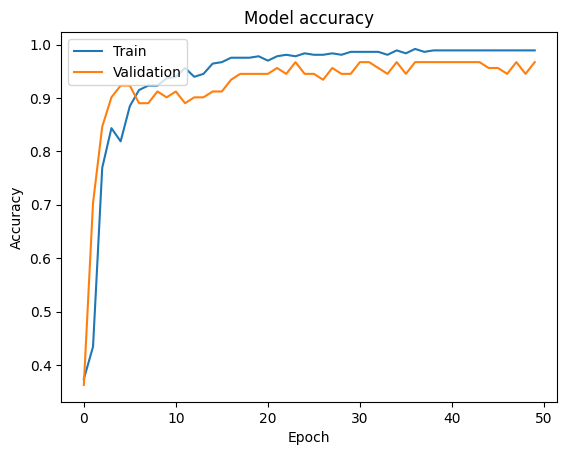

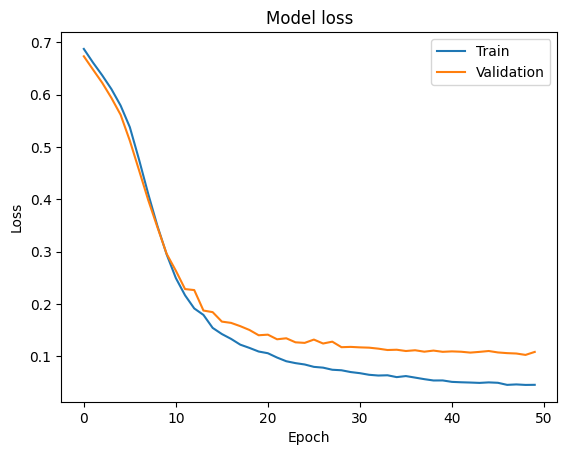

In [32]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

In [33]:
y_pred = model.predict(x_test)


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [34]:
y_pred = (y_pred > .5)


cm = confusion_matrix(y_test, y_pred)
cm



array([[70,  1],
       [ 2, 41]])

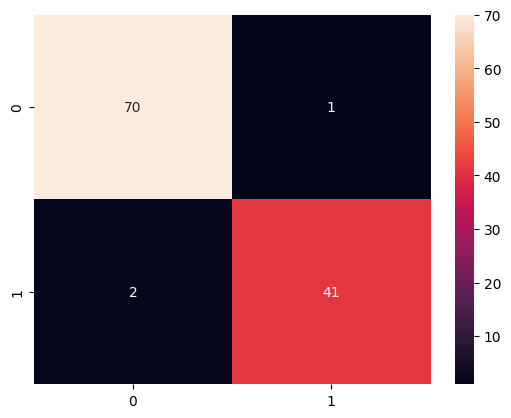

In [35]:
sns.heatmap(cm, annot=True)
plt.show()

In [36]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98        71
           1       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



# **Thank You**